# ESTUDO DE RENTABILIDADE

Em posse de uma base de dados com aproximadamente 12.500 informações transacionais ocorridas entre os meses de outubro 2016 e fevereiro de 2017, apresentamos um estudo acerca da rentabilidade , a fim de definir perfis dos clientes, traçar um plano estratégico para campanha de aquisição de novos clientes e investimento de recursos, bem como  mensurar uma margem líquida para situações em safras futuras. 

In [2]:
!pip install --quiet kmodes

In [3]:
!pip install --quiet cloudpickle

In [4]:
import pandas as pd
import numpy as np
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import time
from sklearn.manifold import TSNE
import cloudpickle as cp
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, ClusterMixin, BaseEstimator
sns.set()
pd.set_option('display.max_columns', None)

In [5]:
# Cria parâmetros de acesso na AWS

NM_BUCKET   = 'turing-bkt-laion-prod'
ID_CLIENTE  = '2020'
CAMINHO     = 'Bases/CASES/STONE'
ARQUIVO     = 'CASE_RentabilidadeAnalítica.csv'

# Carrega credenciais da AWS
S3fs, S3session, S3client, S3resource = TuringUsersCredentialsControl(id_cliente)

In [6]:
df = boto3.client('s3').get_object(Bucket=NM_BUCKET, Key=CAMINHO + ARQUIVO)
df = pd.read_csv(df['Body'], sep=';', encoding='latin-1')
df = df.dropna(subset=['Número do Cliente'])
df['Data de Entrada do Cliente'] = pd.to_datetime(df['Data de Entrada do Cliente'])
df = df.replace(" ", "")
print('A base total contém', df.shape[0], 'linhas e ',df.shape[1],'colunas')

A base total contém 12456 linhas e  19 colunas


## Criação da Variável "Longevidade do Cliente"

In [7]:
def tempo_cliente_dias(df, VARIAVEL_DATA ='Data de Entrada do Cliente'):
    import datetime
    from datetime import date
    hoje = date.today()
    hoje = datetime.datetime(hoje.year,hoje.month,hoje.day)
    tempo_dias = []
    for i in range(0,len(df)):
        tempo = hoje -  datetime.datetime(df[VARIAVEL_DATA][i].year, df[VARIAVEL_DATA][i].month, df[VARIAVEL_DATA][i].day)
        tempo_dias.append(tempo.days)
    return tempo_dias

In [8]:
df['Longevidade do Cliente'] = tempo_cliente_dias(df, VARIAVEL_DATA ='Data de Entrada do Cliente')

## Criação da Base Visão Cliente

In [9]:
df_cli = df.drop_duplicates(subset=['Número do Cliente']) # Base de Dados Visão Cliente
df_cli = df_cli[['Número do Cliente','Longevidade do Cliente', 'MCC', 'Cidade', 'Canal']]
print('A base contém', df_cli.shape[0], 'clientes diferentes, com ',df_cli.shape[1] ,'informações cadastrais.')

A base contém 3194 clientes diferentes, com  5 informações cadastrais.


# 1. Identificação dos Perfis dos Clientes 

## 1.1 Breve exploratório Gráfico da base

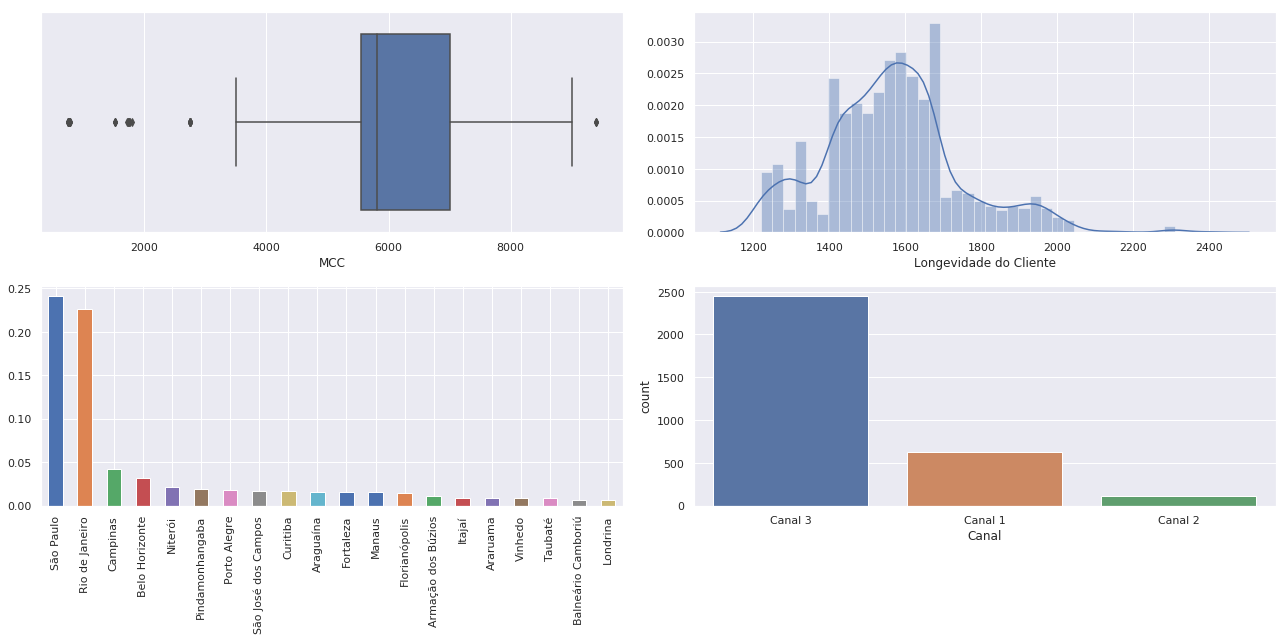

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(18,9))

sns.boxplot(df_cli['MCC'], ax=axs[0,0])
df_cli['Cidade'].value_counts(normalize=True).head(20).plot(kind='bar', ax=axs[1,0])
sns.countplot(df_cli['Canal'], ax=axs[1,1])
sns.distplot(df_cli['Longevidade do Cliente'], ax=axs[0,1])



fig.tight_layout()

## 1.2 Tunagem do Número de Clusters

Para estabelecer o número de clusters vamos utilizar a técnica do cotovelo acerca da minimização da Soma das distâncias ao quadrado a partir do algortimo de clusterização K-Means.

In [11]:
def calcula_k_clusters(base,n_min,n_max,chaves,referencia,cor,variaveis_categoricas):
    base = base.copy()
    for var in variaveis_categoricas:
        for i in range(0,len(pd.unique(base[var]))):
            base.loc[(base[var]==pd.unique(base[var])[i]),var]=i
    data = base
    data = data.drop(chaves,axis=1)
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(n_min,n_max)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-',color = cor)
    plt.xlabel('nº de Clusters')
    plt.ylabel('Soma das distâncias ao quadrado')
    plt.title('Método do Cotovelo para o Nº de Clusters na Base '+referencia)
    plt.show()
    return Sum_of_squared_distances

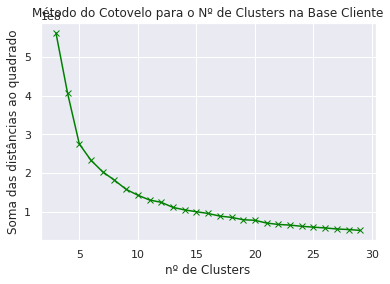

[562548552.2408776,
 405481438.1134395,
 274769924.3479331,
 232420313.96717295,
 202737258.70994225,
 181228643.88085395,
 157391817.76192117,
 142360561.80979165,
 129913096.53937833,
 123855075.83515911,
 110790909.70746285,
 104304509.71160841,
 99590883.9714418,
 95100905.43356813,
 88320983.60270444,
 84978748.42362334,
 78886734.76057439,
 77400673.8110601,
 70257012.726698,
 66706034.17364515,
 64983180.61663585,
 61885143.32998852,
 59646018.11327648,
 57644101.392844014,
 54941075.8675541,
 53546089.45464496,
 51261434.20923153]

In [12]:
calcula_k_clusters(df_cli,3,30,chaves = ['Número do Cliente'],referencia='Cliente',cor='green',variaveis_categoricas = ['Cidade','Canal'])

Assim, definimos 5 clusters para serem trabalhados nos próximos passos.

## 1.3 Aplicação do Algoritmo K-Prototypes

### 1.3.1 Tratando as variáveis (distinguir quem é categórica de numérica)

In [13]:
def converte_numericas(base,variaveis_categoricas):
    for var in variaveis_categoricas:
        base = base.fillna(-999)
        base[var] = base[var].astype(str)
    return base

In [14]:
df_cli_tr = converte_numericas(df_cli,['MCC','Cidade','Canal','Número do Cliente'])

In [15]:
cols_categoricas = ['MCC','Cidade','Canal']
cols_numericas = ['Longevidade do Cliente']

### 1.3.2  Criação das Funções em Formato de Pipeline (Seleção de Variáveis; Tratamento e Normalização das Variáveis; Aplicação do Classificador)

In [16]:
class DataFrameSelector(TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

In [17]:
class ColumnsTransformer(TransformerMixin):
    
    def __init__(self, numerical_imputer='constant', fill_value=0):
        self.numerical_imputer = numerical_imputer
        self.fill_value = fill_value
        self.scaler = RobustScaler(with_centering=False)
        self.imputer = SimpleImputer(strategy=self.numerical_imputer, fill_value=self.fill_value)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.num_cols = X.select_dtypes('number').columns.tolist()
        
        # Scaler
        X[self.num_cols] = self.scaler.fit_transform(X[self.num_cols])
        
        # Imputer
        X[self.num_cols] = self.imputer.fit_transform(X[self.num_cols])
        
        return X

In [18]:
class KProto(TransformerMixin, ClusterMixin, BaseEstimator):
    
    def __init__(self, n_clusters=6, init='Cao', verbose=1, random_state=42, n_jobs=-1):
        self.n_clusters = n_clusters
        self.init = init
        self.verbose = verbose
        self.random_state = random_state
        self.n_jobs = n_jobs
    
    def fit(self, X, y=None):
        self.kproto = KPrototypes(
            n_clusters=self.n_clusters, 
            init=self.init, 
            verbose=self.verbose, 
            random_state=self.random_state, 
            n_jobs=self.n_jobs
        )
        
        if type(X) == pd.DataFrame:
            X = np.array(X)
        
        indices = [i for i in range(len(X[0])) if type(X[0][i]) == str]
        return self.kproto.fit(X, categorical=indices)
    
    def predict(self, X):
        indices = [i for i in range(len(X[0])) if type(X[0][i]) == str]
        return self.kproto.predict(X, categorical=indices)

### 1.3.3 Aplicação da Pipeline de Construção da Base de Modelagem

In [19]:
# pipeline para pré-processamento das variáveis numéricas
num_transformer = Pipeline(steps=[
    ('num_scaler', RobustScaler(with_centering=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

# pipeline para seleção das variáveis categóricas
cat_transformer = Pipeline(steps=[
    ('seleciona_categorica', DataFrameSelector(cols_categoricas))
])

# Compondo os pré-processadores
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, cols_numericas),
    ('cat', cat_transformer, cols_categoricas)
])

# Cria pipeline de clusterização
NCLUSTERS = 5 # Definido na Fase anterior pelo Método do Cotovelo
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('k_proto', KProto(n_clusters=NCLUSTERS, init='Cao', random_state=42, n_jobs=-1))
])

# Separa dataframe para clusterização
cols_clustering = cols_numericas + cols_categoricas
X = df_cli_tr.loc[:, cols_clustering].sample(n=int(len(df_cli_tr)*0.7), random_state=42) # 70% da base será usada na Modelagem

# Prepara índices de categóricas
# indices_categoricas = [X.columns.tolist().index(i) for i in cols_categoricas]

print('Tamanho amostra de desenvolvimento do Modelo:', X.shape[0],'Clientes')
print('Equivalmente da amostra de desenvolvimento do Modelo:', round((X.shape[0]/df_cli_tr.shape[0])*100,2),'%')

Tamanho amostra de desenvolvimento do Modelo: 2235 Clientes
Equivalmente da amostra de desenvolvimento do Modelo: 69.97 %


### 1.3.4 Definição da Base de teste para avaliação de estabilidade dos clusters

In [20]:
df_teste = df_cli_tr[~df_cli_tr.index.isin(X.index.get_values())]
print('Tamanho amostra de teste do Modelo:', df_teste.shape[0],'Clientes')
print('Equivalmente da amostra de teste do Modelo:', round((df_teste.shape[0]/df_cli_tr.shape[0])*100,2),'%')

Tamanho amostra de teste do Modelo: 959 Clientes
Equivalmente da amostra de teste do Modelo: 30.03 %


### 1.3.5 Aplicação da pipeline de construção do Modelo

In [21]:
%%time
pipe.fit(X)

Best run was number 10
CPU times: user 8.71 s, sys: 337 ms, total: 9.05 s
Wall time: 2.15 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_scaler',
                                                                   RobustScaler(with_centering=False)),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['Longevidade do Cliente']),
                                                 ('cat',
                                                  Pipeline(steps=[('seleciona_categorica',
                                                                   <__main__.DataFrameSelector object at 0x7fc4e8ae3cc0>)]),
                                                  ['MCC', 'Cidade',
                          

In [22]:
## Salvando os Cluster como uma nova Variável na Base de Modelagem
X['Cluster'] = pipe.predict(X)
X['Cluster'] = [f'Cluster {i}' for i in X['Cluster']]

## Salvando os Cluster como uma nova Variável na Base de Teste
df_teste['Cluster'] = pipe.predict(df_teste)
df_teste['Cluster'] = [f'Cluster {i}' for i in df_teste['Cluster']]

### 1.3.6 Criação de Pipeline para Visualização em 2D

In [23]:
# Cria pipeline para tsne
pipe_tsne = Pipeline(steps=[
    ('numericas', DataFrameSelector(cols_numericas)),
    ('num_scaler', RobustScaler(with_centering=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('tsne', TSNE(n_components=2, verbose=1, n_jobs=-1, random_state=42))
])

### 1.3.7 Aplicação da  Pipeline de Visualização 2D através do TSNE

In [24]:
# Decompondo pelo tSNE na Base de Modelagem
time_start = time.time()
tsne_results = pipe_tsne.fit_transform(X)
print('t-SNE concluído! Tempo decorrido: {:.4f} minutos'.format((time.time() - time_start) / 60))
X['tsne-2d-X'] = tsne_results[:,0]
X['tsne-2d-Y'] = tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2235 samples in 0.001s...
[t-SNE] Computed neighbors for 2235 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2235
[t-SNE] Computed conditional probabilities for sample 2000 / 2235
[t-SNE] Computed conditional probabilities for sample 2235 / 2235
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.085152
[t-SNE] KL divergence after 1000 iterations: 0.114805
t-SNE concluído! Tempo decorrido: 0.0538 minutos


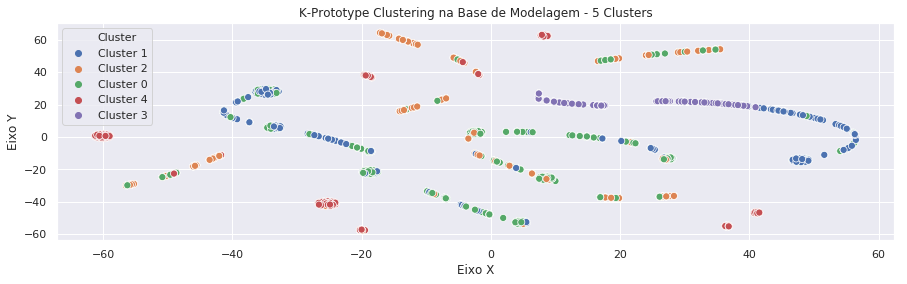

In [25]:
plt.figure(figsize=(15,4))
palette = sns.color_palette('deep', NCLUSTERS)
sns.scatterplot(x='tsne-2d-X', y='tsne-2d-Y', data=X, palette=palette, legend='full', hue='Cluster', s=50)
plt.title(f'K-Prototype Clustering na Base de Modelagem - {NCLUSTERS} Clusters')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.show()

In [26]:
# Decompondo pelo tSNE na Base de Teste
time_start = time.time()
tsne_results = pipe_tsne.fit_transform(df_teste)
print('t-SNE concluído! Tempo decorrido: {:.4f} minutos'.format((time.time() - time_start) / 60))
df_teste['tsne-2d-X'] = tsne_results[:,0]
df_teste['tsne-2d-Y'] = tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 959 samples in 0.000s...
[t-SNE] Computed neighbors for 959 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 959 / 959
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.230583
[t-SNE] KL divergence after 1000 iterations: 0.113372
t-SNE concluído! Tempo decorrido: 0.0269 minutos


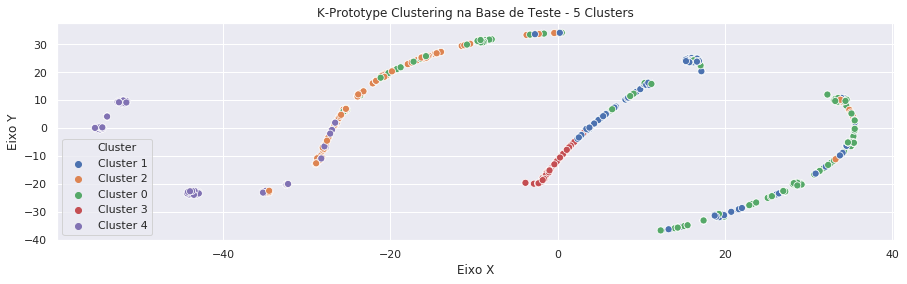

In [27]:
plt.figure(figsize=(15,4))
palette = sns.color_palette('deep', NCLUSTERS)
sns.scatterplot(x='tsne-2d-X', y='tsne-2d-Y', data=df_teste, palette=palette, legend='full', hue='Cluster', s=50)
plt.title(f'K-Prototype Clustering na Base de Teste - {NCLUSTERS} Clusters')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.show()

In [28]:
print('Distribuição dos Clustersna Base de Modelagem:'),
print(round((X['Cluster'].value_counts(normalize=True).sort_index()*100),2),'em %')

Distribuição dos Clustersna Base de Modelagem:
Cluster 0    30.92
Cluster 1    24.21
Cluster 2    20.22
Cluster 3     9.66
Cluster 4    14.99
Name: Cluster, dtype: float64 em %


In [29]:
print('Distribuição dos Clusters de Teste:'),
print(round((df_teste['Cluster'].value_counts(normalize=True).sort_index()*100),2),'em %')

Distribuição dos Clusters de Teste:
Cluster 0    30.87
Cluster 1    22.84
Cluster 2    20.65
Cluster 3     9.91
Cluster 4    15.75
Name: Cluster, dtype: float64 em %


Pode-se entender que os cluters escolhidos parecem bem estáveis quanto à distribuição (volumetria). Sendo assim, seguimos com eles para as etapas seguintes.

## 1.4 Hierarquização dos Clientes a Partir de algumas métricas de desempenho

In [30]:
df_cli_tr['Cluster'] = pipe.predict(df_cli_tr)
df_cli_tr['Cluster'] = [f'Cluster {i}' for i in df_cli_tr['Cluster']]

In [31]:
df.shape

(12456, 20)

In [32]:
df['Número do Cliente']= df['Número do Cliente'].astype(str)
df = pd.merge(df, df_cli_tr[['Número do Cliente','Cluster']], on='Número do Cliente')

In [33]:
df.shape

(12456, 21)

In [34]:
def transforma_variaveis(df,variaveis):
    for var in variaveis:
        step =[]
        for i in range(0,len(df)):
            step.append(df[var][i].split(',')[0])
        df[var]=step
        df[var]= pd.to_numeric(df[var])
    return df 

In [35]:
variaveis = [' Volume Transacionado ', ' Quantidade de Transações ',
       ' Net MDR ', ' Aluguel ', ' Pre-pagamento ', ' Total ',
       ' Pre-pagamento .1', ' Equipamento/Logística ', ' Comissões ',
       ' Transacionais ', ' Outros ', ' Total .1', ' Margem final ']
df = transforma_variaveis(df,variaveis)

In [36]:
print('Análise de Longevidade Média, em Anos, do Cliente Por Cluster:'),
print('Cluster 0:',round(((df[df['Cluster']=='Cluster 0']['Longevidade do Cliente'])/365).mean(),2)),
print('Cluster 1:',round(((df[df['Cluster']=='Cluster 1']['Longevidade do Cliente'])/365).mean(),2)),
print('Cluster 2:',round(((df[df['Cluster']=='Cluster 2']['Longevidade do Cliente'])/365).mean(),2)),
print('Cluster 3:',round(((df[df['Cluster']=='Cluster 3']['Longevidade do Cliente'])/365).mean(),2)),
print('Cluster 4:',round(((df[df['Cluster']=='Cluster 4']['Longevidade do Cliente'])/365).mean(),2)),
print(),
print('Análise de Volume Transacionado Médio Por Cluster:'),
print('Cluster 0:',round(df[df['Cluster']=='Cluster 0'][' Volume Transacionado '].mean(),0)),
print('Cluster 1:',round(df[df['Cluster']=='Cluster 1'][' Volume Transacionado '].mean(),0)),
print('Cluster 2:',round(df[df['Cluster']=='Cluster 2'][' Volume Transacionado '].mean(),0)),
print('Cluster 3:',round(df[df['Cluster']=='Cluster 3'][' Volume Transacionado '].mean(),0)),
print('Cluster 4:',round(df[df['Cluster']=='Cluster 4'][' Volume Transacionado '].mean(),0))
print(),
print('Análise de Margem de Lucro Média Por Cluster:'),
print('Cluster 0:',round(df[df['Cluster']=='Cluster 0'][' Margem final '].mean(),0)),
print('Cluster 1:',round(df[df['Cluster']=='Cluster 1'][' Margem final '].mean(),0)),
print('Cluster 2:',round(df[df['Cluster']=='Cluster 2'][' Margem final '].mean(),0)),
print('Cluster 3:',round(df[df['Cluster']=='Cluster 3'][' Margem final '].mean(),0)),
print('Cluster 4:',round(df[df['Cluster']=='Cluster 4'][' Margem final '].mean(),0))
print(),
print('Análise de Distribuição de Canal Por Cluster:'),
pd.crosstab(df['Canal'], 
            df['Cluster'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1)

Análise de Longevidade Média, em Anos, do Cliente Por Cluster:
Cluster 0: 4.29
Cluster 1: 4.56
Cluster 2: 3.99
Cluster 3: 5.22
Cluster 4: 3.66

Análise de Volume Transacionado Médio Por Cluster:
Cluster 0: 34771.0
Cluster 1: 51980.0
Cluster 2: 35898.0
Cluster 3: 57870.0
Cluster 4: 55373.0

Análise de Margem de Lucro Média Por Cluster:
Cluster 0: 295.0
Cluster 1: 493.0
Cluster 2: 329.0
Cluster 3: 391.0
Cluster 4: 272.0

Análise de Distribuição de Canal Por Cluster:


Cluster,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Canal,,,,,
Canal 1,0.333497,0.223310,0.218413,0.141528,0.083252
Canal 2,0.601869,0.097196,0.224299,0.000000,0.076636
Canal 3,0.302966,0.253973,0.233526,0.112056,0.097480


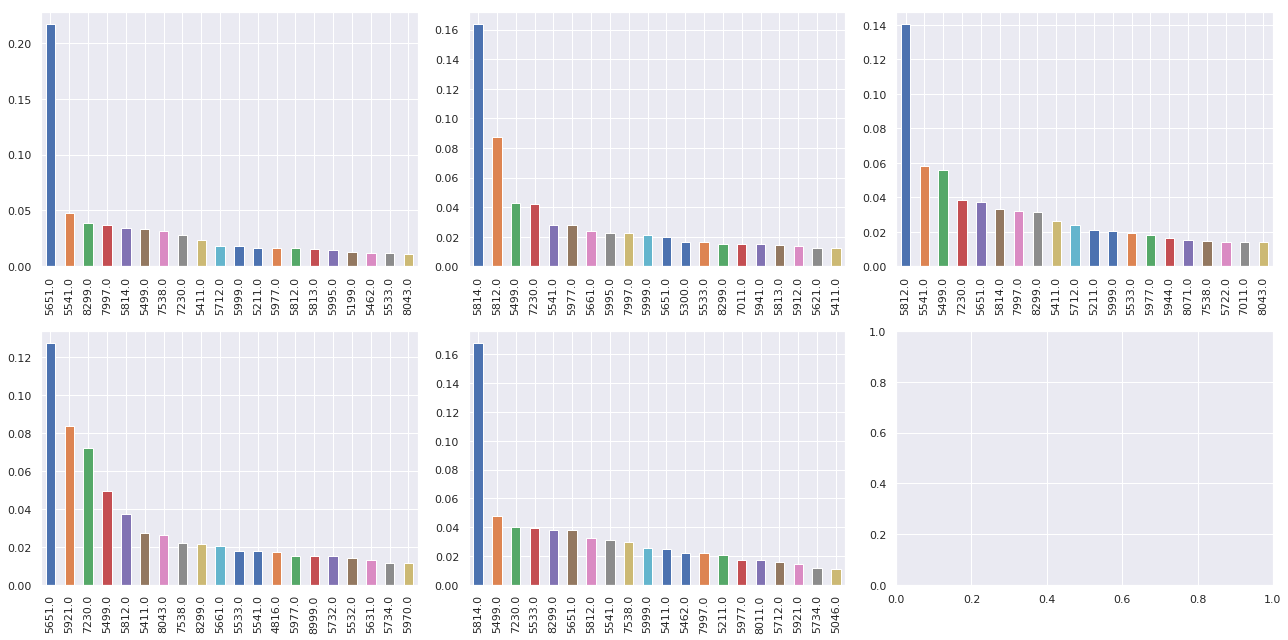

In [37]:
df_cli_CL0 = df[df['Cluster']=='Cluster 0']
df_cli_CL1 = df[df['Cluster']=='Cluster 1']
df_cli_CL2 = df[df['Cluster']=='Cluster 2']
df_cli_CL3 = df[df['Cluster']=='Cluster 3']
df_cli_CL4 = df[df['Cluster']=='Cluster 4']
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18,9))

df_cli_CL0['MCC'].value_counts(normalize=True).head(20).plot(kind='bar', ax=axs[0,0])
df_cli_CL1['MCC'].value_counts(normalize=True).head(20).plot(kind='bar', ax=axs[0,1])
df_cli_CL2['MCC'].value_counts(normalize=True).head(20).plot(kind='bar', ax=axs[0,2])
df_cli_CL3['MCC'].value_counts(normalize=True).head(20).plot(kind='bar', ax=axs[1,0])
df_cli_CL4['MCC'].value_counts(normalize=True).head(20).plot(kind='bar', ax=axs[1,1])

fig.tight_layout()

Assim podemos descrever qualitativamente os 5 perfis traçados como:

Cluster 0 = Cliente predominantemente do Canal 2, com tempo de relacionamento médio com a empresa, baixo volume transacionado, baixa perspectiva de lucro e MCC de maior frequência igual a 5651;

Cluster 1 = Cliente predominantemente dos Canais 1 e 3, com tempo de relacionamento médio-alto com a empresa, alto volume transacionado, alta perspectiva de lucro  e MCC de maior frequência igual a 5814;

Cluster 2 = Cliente sem predominância de Canal, com tempo de relacionamento baixo com a empresa, baixo volume transacionado, média perspectiva de lucro e MCC de maior frequência igual a 5812;


Cluster 3 = Cliente predominantemente dos Canais 1 e 3, com tempo de relacionamento alto com a empresa, alto volume transacionado, média-alta perspectiva de lucro e MCC de maior frequência igual a 5651;

Cluster 4 = Cliente sem predominância de Canal, com tempo de relacionamento baixo com a empresa, médio-alto volume transacionado, baixa perspectiva de lucro e MCC de maior frequência igual a 5814;

# 2. Análise de Estratégia acerca dos Perfis definidos na etapa anterior

[Churn do mês de novembro] = [Número de clientes inativos* em novembro que estavam ativos* em outubro] / [Número de clientes ativos* em outubro];

### 2.1 Análise por Churn

In [38]:
def churn_1(base):
    frames_inativos = []
    frames_ativos = []
    for i in range(0,len(pd.unique(base['Data Apuração']))):
        frames_inativos.append(base[(base['Data Apuração']==pd.unique(base['Data Apuração'])[i]) & (base[' Quantidade de Transações ']==0)])
        frames_ativos.append(base[(base['Data Apuração']==pd.unique(base['Data Apuração'])[i]) & (base[' Quantidade de Transações ']!=0)])
    return frames_inativos , frames_ativos   

def churn_2(frames,safras, ref):
    churns = []
    for i in range(0,(len(frames[0])-1)):
        churns.append(round(sum((frames[0][i+1]['Número do Cliente']).isin(frames[1][i]['Número do Cliente']))/len(frames[1][i]['Número do Cliente']),4)*1000)
    resumo = pd.DataFrame({'Safra':safras,'Churn '+ref:churns})
    resumo = resumo[['Safra','Churn '+ref]]
    return resumo

In [39]:
safra = ['Novembro 2016','Dezembro 2016','Janeiro 2017','Fevereiro 2017']
frame_cl0 = churn_1(df_cli_CL0)
churn_cl0 = churn_2(frame_cl0,safra,"Cluster 0")
frame_cl1 = churn_1(df_cli_CL1)
churn_cl1 = churn_2(frame_cl1,safra,"Cluster 1")
frame_cl2 = churn_1(df_cli_CL2)
churn_cl2 = churn_2(frame_cl2,safra,"Cluster 2")
frame_cl3 = churn_1(df_cli_CL3)
churn_cl3 = churn_2(frame_cl3,safra,"Cluster 3")
frame_cl4 = churn_1(df_cli_CL4)
churn_cl4 = churn_2(frame_cl4,safra,"Cluster 4")
frame = churn_1(df)
churn = churn_2(frame,safra," Base Full")

In [40]:
from functools import reduce
reduce(lambda  left,right: pd.merge(left,right,on=['Safra'],
       how='outer'), [churn_cl0,churn_cl1,churn_cl2,churn_cl3,churn_cl4,churn])

,Safra,Churn Cluster 0,Churn Cluster 1,Churn Cluster 2,Churn Cluster 3,Churn Cluster 4,Churn Base Full
0,Novembro 2016,57.4,67.2,55.7,53.2,93.2,61.1
1,Dezembro 2016,59.6,55.7,66.1,30.3,63.1,57.5
2,Janeiro 2017,70.0,61.6,72.8,85.4,54.5,69.1
3,Fevereiro 2017,62.3,47.0,54.9,10.9,72.6,53.3


### 2.2 Análise por Custo de Aquisição

In [41]:
def custo(base):
    base.loc[(base['Canal']== 'Canal 1'),'Custo'] = 1200
    base.loc[(base['Canal']== 'Canal 2'),'Custo'] = 1200
    base.loc[(base['Canal']== 'Canal 3'),'Custo'] = 800
    return base  

In [42]:
df_cli_CL0 = custo(df_cli_CL0)
df_cli_CL1 = custo(df_cli_CL1)
df_cli_CL2 = custo(df_cli_CL2)
df_cli_CL3 = custo(df_cli_CL3)
df_cli_CL4 = custo(df_cli_CL4)

In [43]:
pd.DataFrame({'Cluster':[pd.unique(df_cli_CL0['Cluster'])[0],pd.unique(df_cli_CL1['Cluster'])[0],pd.unique(df_cli_CL2['Cluster'])[0],
                        pd.unique(df_cli_CL3['Cluster'])[0],pd.unique(df_cli_CL4['Cluster'])[0]],
              'Custo':[df_cli_CL0['Custo'].sum(),df_cli_CL1['Custo'].sum(),df_cli_CL2['Custo'].sum(),df_cli_CL3['Custo'].sum(),
                       df_cli_CL4['Custo'].sum()]})

,Cluster,Custo
0,Cluster 0,3598000.0
1,Cluster 1,2616800.0
2,Cluster 2,2524800.0
3,Cluster 3,1232400.0
4,Cluster 4,1023600.0


Como pode-se observar nas análises de custo e de churn, o Cluster 3 é um dos de  menor custo, bem como um dos de maior tempo de vida médio (ou seja, menor churn). Aliado à isso, quando consideramos as análises descritivas dos clusters (apresentadas na etapa anterior), observamos uma boa perspectiva de lucro oriunda desse perfil. Assim, uma sugestão seria investir mais na aquisição de clientes do Cluster 3, e consequentemente, nos canais 1 e 3. 

Quanto aos clientes que já contrataram o produto, seria interessante criar uma iniciativa para reter o cliente do Cluster 1. Como destacado ao longo do estudo, ele é um cliente com boas características quanto a longevidade de relacionamento e perspectiva de lucro, mas apresenta um churn relativamente alto (ou seja, baixo tempo de vida médio). Talvez, uma alternativa seja criar algum programa de fidelidade  voltado ao uso recorrente do produto. 

## 3. Previsão de Receita e Lucro

### 3.1 Criação de um Modelo para previsão de Lucro com bas na Rentabilização da Base e nas Vendas Mensais

In [44]:
def base_forecast_lucro(base):
    RENTABILIZACAO = []
    VENDAS_MENSAIS = []
    LUCRO = []
    SAFRA = list(np.unique(df['Data Apuração']))
    for i in range(0,len(np.unique(base['Data Apuração']))):
        RENTABILIZACAO.append(base[base['Data Apuração']==np.unique(base['Data Apuração'])[i]][' Volume Transacionado '].sum())
        VENDAS_MENSAIS.append(len(base[(base['Data Apuração']==np.unique(base['Data Apuração'])[i]) & (base[' Quantidade de Transações ']!=0)]))
        LUCRO.append(base[base['Data Apuração']==np.unique(base['Data Apuração'])[i]][' Margem final '].sum())
    resumo = pd.DataFrame({'Rentabilização da Base':RENTABILIZACAO,
                           'Novas Vendas Mensais':VENDAS_MENSAIS,
                           'Margem de Lucro':LUCRO,'Safras':SAFRA})
    return resumo

In [45]:
df_forecast = base_forecast_lucro(df)
df_forecast

,Margem de Lucro,Novas Vendas Mensais,Rentabilização da Base,Safras
0,1155227,2025,113417416,01/01/2017
1,969578,2094,99668190,01/02/2017
2,697291,1719,96330500,01/10/2016
3,779190,1877,117572598,01/11/2016
4,877698,1997,117709579,01/12/2016


In [46]:
X_train = df_forecast[(df_forecast['Safras']!='01/01/2017') | 
                      (df_forecast['Safras']!='01/02/2017')].drop(['Margem de Lucro',
                                                                  'Safras'],axis=1)
X_test = df_forecast[(df_forecast['Safras']=='01/01/2017')].drop(['Margem de Lucro',
                                                                  'Safras'],axis=1)
X_oot = df_forecast[(df_forecast['Safras']=='01/02/2017')].drop(['Margem de Lucro',
                                                                  'Safras'],axis=1)
y_train = df_forecast[(df_forecast['Safras']!='01/01/2017') | 
                      (df_forecast['Safras']!='01/02/2017')]['Margem de Lucro']
y_test = df_forecast[(df_forecast['Safras']=='01/01/2017')]['Margem de Lucro']
y_oot = df_forecast[(df_forecast['Safras']=='01/02/2017')]['Margem de Lucro']

In [47]:
def modelo_xgb(X,y,X_teste,y_teste):
    import xgboost
    from xgboost import plot_importance
    from sklearn.metrics import mean_absolute_error
    from scipy.stats import skew
    from collections import OrderedDict
    erro_treino = []
    erro_teste = []
    aprendizado = np.arange(0.01, 1, 0.01).tolist()
    for i in np.arange(0.01, 1, 0.01).tolist():
        regr = xgboost.XGBRegressor(colsample_bytree=0.4,
        gamma=0,                 
        learning_rate=i,
        max_depth=3,
        min_child_weight=1.5,
        n_estimators=10000,                                                                    
        reg_alpha=0.75,
        reg_lambda=0.45,
        subsample=0.6,
        seed=42)
        regr.fit(X, y)
        erro_treino.append(mean_absolute_error(y,(regr.predict(X))))
        erro_teste.append(mean_absolute_error(y_teste, regr.predict(X_teste)))
        print('Tx de Aprendizado:',i)
    resumo_desempenho = pd.DataFrame({'learning_rate':aprendizado,'Erro Treino':erro_treino,'Erro Teste':erro_teste})
    return resumo_desempenho

    

In [48]:
performances = modelo_xgb(X_train,y_train,X_test,y_test)

[11:21:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.01
[11:21:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.02
[11:21:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.03
[11:21:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.04
[11:21:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.05
[11:21:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.060000000000000005
[11:21:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear

Tx de Aprendizado: 0.54
[11:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.55
[11:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.56
[11:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.5700000000000001
[11:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.5800000000000001
[11:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.59
[11:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tx de Aprendizado: 0.6
[11:22:12] WARNING: /workspace/src/objectiv

In [52]:
import xgboost
from sklearn.metrics import mean_absolute_error
melhor_modelo = xgboost.XGBRegressor(colsample_bytree=0.4,
gamma=0,                 
learning_rate=0.12,
max_depth=3,
min_child_weight=1.5,
n_estimators=10000,                                                                    
reg_alpha=0.75,
reg_lambda=0.45,
subsample=0.6,
seed=42)
melhor_modelo.fit(X_train, y_train)

[11:24:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, learning_rate=0.12, min_child_weight=1.5,
             n_estimators=10000, reg_alpha=0.75, reg_lambda=0.45, seed=42,
             subsample=0.6)

In [54]:
erro_treino = mean_absolute_error(y_train,(melhor_modelo.predict(X_train)))
erro_teste= mean_absolute_error(y_test, melhor_modelo.predict(X_test))
erro_oot= mean_absolute_error(y_oot, melhor_modelo.predict(X_oot))
resumo_desempenho = pd.DataFrame({'Erro Treino':[erro_treino],'Erro Teste':[erro_teste],'Erro Out of Time':[erro_oot]})

In [55]:
resumo_desempenho

,Erro Out of Time,Erro Teste,Erro Treino
0,1.0625,0.875,0.9625


### 3.2 Atualização da Base a partir dos incrementos nos canais sugeridos e predição do lucro para uma futura Safra (3 meses á frente de fevereiro de 2017

In [73]:
NOVAS_VENDAS_MENSAL_canal_1_3 = round(len(df[((df['Canal']=='Canal 1')|(df['Canal']=='Canal 3'))&
   (df[' Quantidade de Transações ']!=0)&
   (df['Data Apuração']=='01/02/2017')])*1.05*1.05*1.05,0)


NOVAS_VENDAS_MENSAL_canal_2 = round(len(df[(df['Canal']=='Canal 2')&
   (df[' Quantidade de Transações ']!=0)&
   (df['Data Apuração']=='01/02/2017')]),0)

RENTABILIZACAO_canal_1_3= round((df[(df['Data Apuração']=='01/02/2017') &
                   ((df['Canal']=='Canal 1')|(df['Canal']=='Canal 3'))][' Volume Transacionado '].sum())*1.03*1.03*1.03,0)
                   
RENTABILIZACAO_canal_2= round((df[(df['Data Apuração']=='01/02/2017') &
                   (df['Canal']=='Canal 2')][' Volume Transacionado '].sum())*1.03*1.03*1.03,0)
                   


In [74]:
NOVAS_VENDAS_MENSAIS = NOVAS_VENDAS_MENSAL_canal_1_3 + NOVAS_VENDAS_MENSAL_canal_2
RENTABILIZACAO = RENTABILIZACAO_canal_1_3 +RENTABILIZACAO_canal_2

In [78]:
X_futuro = pd.DataFrame({'Rentabilização da Base':[RENTABILIZACAO],
                           'Novas Vendas Mensais':[NOVAS_VENDAS_MENSAIS]})

In [84]:
print('Assim, a previsão de lucro para o mês de maio de 2017, com base em um crescimento mensal de 5% da Base Ativa e de 3% de volume transacionado, dos canais 1 e 3, é:',melhor_modelo.predict(X_futuro)[0])

Assim, a previsão de lucro para o mês de maio de 2017, com base em um crescimento mensal de 5% da Base Ativa e de 3% de volume transacionado, dos canais 1 e 3, é: 1155226.1
